## Import dependencies

In [44]:
import os

import tensorflow as tf
# import tensorflow.keras
import pandas as pd
import numpy as np
import carball.json_parser.game as game_module
Game = game_module.Game

# pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 70)
# pd.set_option('display.width', 1000)

In [45]:
print(tf.__version__)
print(tf.test.is_gpu_available()) # tells if the gpu is available
print(tf.test.gpu_device_name()) # returns the name of the gpu device

2.0.1
True
/device:GPU:0


In [46]:
# defaults
def should_parse_replays(): return False
X_path = './data/X.csv'
y_path = './data/y.csv'

In [47]:
# replay_path = './parsed_replays/rlcs_season_7/'
replay_path = './parsed_replays/'
!ls parsed_replays/

'Kevpert_temp (1).json'   'Kevpert_temp (23).json'  'Syracks_temp (12).json'
'Kevpert_temp (10).json'  'Kevpert_temp (24).json'  'Syracks_temp (14).json'
'Kevpert_temp (11).json'  'Kevpert_temp (25).json'  'Syracks_temp (16).json'
'Kevpert_temp (12).json'  'Kevpert_temp (26).json'  'Syracks_temp (17).json'
'Kevpert_temp (13).json'  'Kevpert_temp (27).json'  'Syracks_temp (2).json'
'Kevpert_temp (14).json'  'Kevpert_temp (3).json'   'Syracks_temp (3).json'
'Kevpert_temp (15).json'  'Kevpert_temp (4).json'   'Syracks_temp (4).json'
'Kevpert_temp (16).json'  'Kevpert_temp (5).json'   'Syracks_temp (5).json'
'Kevpert_temp (17).json'  'Kevpert_temp (6).json'   'Syracks_temp (6).json'
'Kevpert_temp (18).json'  'Kevpert_temp (7).json'   'Syracks_temp (7).json'
'Kevpert_temp (19).json'  'Kevpert_temp (8).json'   'Syracks_temp (8).json'
'Kevpert_temp (2).json'   'Kevpert_temp (9).json'   'Syracks_temp (9).json'
'Kevpert_temp (20).json'   Kevpert_temp.json	     Syracks_temp.json
'Kevpert_temp (2

In [48]:
game_files = []
path = './replays/rlcs_season_7/'
for filename in os.listdir(replay_path):
  if filename.endswith('.json'):
    game_files.append(replay_path + filename)
# game_files = game_files[0:8] # TEST - use subset of games for now
print(len(game_files))
print(list(game_files))

43
['./parsed_replays/Syracks_temp (12).json', './parsed_replays/Kevpert_temp (27).json', './parsed_replays/Syracks_temp (6).json', './parsed_replays/Kevpert_temp (16).json', './parsed_replays/Syracks_temp (17).json', './parsed_replays/Syracks_temp (11).json', './parsed_replays/Kevpert_temp (5).json', './parsed_replays/Syracks_temp (4).json', './parsed_replays/Syracks_temp (5).json', './parsed_replays/Syracks_temp.json', './parsed_replays/Kevpert_temp (17).json', './parsed_replays/Kevpert_temp (24).json', './parsed_replays/Kevpert_temp (12).json', './parsed_replays/Kevpert_temp (14).json', './parsed_replays/Syracks_temp (7).json', './parsed_replays/Kevpert_temp (23).json', './parsed_replays/Kevpert_temp (26).json', './parsed_replays/Kevpert_temp (18).json', './parsed_replays/Syracks_temp (2).json', './parsed_replays/Kevpert_temp (2).json', './parsed_replays/Kevpert_temp.json', './parsed_replays/Kevpert_temp (22).json', './parsed_replays/Kevpert_temp (7).json', './parsed_replays/Syracks

In [49]:
def get_game(file_path):
  game = game_module.Game()
  game.initialize(file_path=file_path)
  return game

if len(game_files) > 0:
  game = game_module.Game()
  game.initialize(
      file_path=game_files[0])
else:
  raise IndexError('No game_files to parse.')

In [50]:
game.map

'Underwater_P'

In [51]:
game.players

[Player: Syracks on Team: Orange, Player: Ekon on Team: Blue]

In [52]:
print(game.ball.shape)
game.ball.head(3)

(5256, 13)


,pos_x,pos_y,pos_z,rot_x,rot_y,rot_z,vel_x,vel_y,vel_z,ang_vel_x,ang_vel_y,ang_vel_z,hit_team_no
1,0.0,0.0,92.74,0.000005,0.000005,0.000005,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.0,0.0,92.74,0.000005,0.000005,0.000005,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.0,0.0,92.74,0.000005,0.000005,0.000005,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [53]:
game.players[0].name

'Syracks'

In [54]:
game.__dict__.keys()

dict_keys(['file_path', 'properties', 'replay_id', 'map', 'name', 'id', 'datetime', 'replay_version', 'teams', 'players', 'goals', 'primary_player', 'frames', 'kickoff_frames', 'ball', 'ball_type', 'demos', 'parties', 'dropshot', 'match_type', 'team_size', 'game_info'])

In [55]:
game.properties.keys()
# game.game_info.__dict__.keys()

dict_keys(['MaxChannels', 'GameVersion', 'BuildVersion', 'Team1Score', 'KeyframeDelay', 'ReserveMegabytes', 'PlayerStats', 'MaxReplaySizeMB', 'NumFrames', 'MatchType', 'MapName', 'BuildID', 'Goals', 'ReplayVersion', 'Changelist', 'Date', 'ReplayName', 'UnfairTeamSize', 'PrimaryPlayerTeam', 'ReplayLastSaveVersion', 'Id', 'Team0Score', 'TeamSize', 'RecordFPS', 'HighLights'])

In [56]:
player_0_data = game.players[0].data
print(player_0_data.shape)
player_0_data.head(10)
start = 0
data = player_0_data.iloc[start:start + 10]

(5256, 23)


In [57]:
def equalize_player_data_rows(game):
  '''
  Updates the game data to ensure all player data lines up.
  Modifies the game object in place.
  '''
  # @TODO Update this for efficiency using the following:
    # https://stackoverflow.com/questions/48864923/pythonpandas-select-certain-rows-by-index-of-another-dataframe

  # @TODO Merge ball data as well!

  player1 = game.players[0]
  other_players = game.players[1:]
  columns = player1.data.columns
  ball_columns = game.ball.columns
  changed_ball_columns = list(map(lambda x: x + '_ball', ball_columns))
  merged_player_data = player1.data

  game.ball.columns = changed_ball_columns

  for i, player in enumerate(other_players):
    suffix = f'_p{i + 2}'
    merged_player_data = merged_player_data.merge(player.data, left_index=True, right_index=True, suffixes=('', suffix))
  merged_player_data = merged_player_data.merge(game.ball, left_index=True, right_index=True)

  game.ball = merged_player_data[changed_ball_columns]
  game.ball.columns = ball_columns

  game.players[0].data = merged_player_data[columns]
  for i, player in enumerate(game.players[1:]):
    suffixed_columns = list(map(lambda x: x + f'_p{i + 2}', columns))
    game.players[i + 1].data = merged_player_data[suffixed_columns]
    game.players[i + 1].data.columns = columns

In [58]:
game.ball.describe()

,pos_x,pos_y,pos_z,rot_x,rot_y,rot_z,vel_x,vel_y,vel_z,ang_vel_x,ang_vel_y,ang_vel_z,hit_team_no
count,5256.000000,5256.000000,5256.000000,5256.000000,5256.000000,5256.000000,3996.000000,3996.000000,3996.000000,3996.000000,3996.000000,3996.000000,4202.000000
mean,-49.628590,-203.195344,397.690373,0.073363,0.018239,-0.052731,15.628704,27.050025,64.881832,-190.464965,-764.295295,271.473473,0.437649
std,1932.421555,2993.208009,423.016474,0.645472,1.566474,1.524223,9884.393140,10229.627418,5264.383116,3023.495107,2724.825551,2787.034662,0.496156
min,-4002.880000,-5213.380000,81.760000,-1.551841,-3.140201,-3.138239,-21323.100000,-30712.000000,-17357.200000,-5924.900000,-5985.300000,-5983.000000,0.000000
25%,-1044.942500,-2743.270000,93.150000,-0.365331,-0.973011,-1.168169,-6466.150000,-7116.650000,-2185.100000,-2538.200000,-2865.400000,-2077.250000,0.000000
50%,0.000000,0.000000,168.010000,0.000005,0.000005,0.000005,-314.500000,350.500000,0.000000,0.000000,-285.200000,0.000000,0.000000
75%,785.870000,1774.097500,533.480000,0.510718,1.089568,0.995632,5127.475000,5783.800000,2252.575000,2128.300000,967.100000,2193.775000,1.000000
max,4001.870000,5214.440000,1965.310000,1.564324,3.140724,3.140767,33756.300000,26763.300000,21292.000000,5798.300000,5682.300000,5951.000000,1.000000


In [59]:
def get_game_state_columns():
    return [ # built-in columns only - no added data
        'pos_x',
        'pos_y',
        'pos_z',
        'rot_x',
        'rot_y',
        'rot_z',
        'vel_x',
        'vel_y',
        'vel_z',
        'ang_vel_x',
        'ang_vel_y',
        'ang_vel_z',
        'active',
        'boost',
    ]

def get_controller_input_columns():
    return [
        'throttle',
        'steer',
        'handbrake',
        'dodge_active',
        'double_jump_active',
        'jump_active',
        'boost_active',
    ]

def get_ball_columns():
    return [
        'pos_x',
        'pos_y',
        'pos_z',
        'vel_x',
        'vel_y',
        'vel_z',
    ]

In [60]:
def add_active_column(df):
    '''Returns a new dataframe with an extra 'action' column.
    '''
    dataframe = df.assign(active=(~np.isnan(df['steer'])).astype(int))
    return dataframe

In [61]:
def squeeze_value(value, fudge_factor=0.10):
  '''Squeezes 0-1 values between, say, 0.05-0.95 for sigmoid activations.
  '''
  return value # hack - do not squeeze value if not using sigmoid activations.
  return value * (1 - fudge_factor) + (fudge_factor / 2)

def normalize_data(dataframe, fudge_factor=0.10):
  '''
  Returns a normalized copy of a dataframe.
  Fudges the data to place it between (say) 0.025-0.975 instead of 0-1.
  The dataframe provided should contain only numerical data.
  Provides simple min-max normalization.
  '''
  normalized = (dataframe - dataframe.min()) / (dataframe.max() - dataframe.min())
  # return normalized * (1 - fudge_factor) + (fudge_factor / 2)
  return squeeze_value(normalized, fudge_factor)

def normalize_player_data(player_df, main_player=False):
  '''
  Returns a normalized dataframe of player data. Normalizes only numerical data.
  '''
  cols_to_normalize = player_df.select_dtypes(include=np.number).columns.tolist()
  cols = player_df[cols_to_normalize]
  return normalize_data(cols)

In [62]:
def clean_player_data(player_df, main_player=False, team=None):
    '''Handles cleaning, copying, etc. of a player dataframe.
    '''
    with_active = add_active_column(player_df)
    str_bool_to_int = { 'True': 1, 'False': 0, np.nan: 0, None: 0 }
    
    # convert odd-number based activations to 0 and 1
    def odd_num_to_bool(num):
      # if np.isnan(num): return 0
      return int(num % 2 == 1)
    with_active['dodge_active'] = with_active['dodge_active'].apply(odd_num_to_bool)
    with_active['jump_active'] = with_active['jump_active'].apply(odd_num_to_bool)
    with_active['double_jump_active'] = with_active['double_jump_active'].apply(odd_num_to_bool)

    dtypes_map = dict(with_active.dtypes)
    if dtypes_map['ball_cam'] == np.bool:
      with_active['ball_cam'] = with_active['ball_cam'].astype(int)
    elif dtypes_map['ball_cam'] == np.str:
      with_active['ball_cam'] = with_active.replace({ 'ball_cam': str_bool_to_int })

    cleaned = with_active.replace({
        'handbrake': str_bool_to_int,
        # 'ball_cam': str_bool_to_int,
        # 'boost_active': str_bool_to_int
        # 'double_jump_active': str_bool_to_int,
    })

    cleaned = cleaned.fillna(0)

    if not main_player:
        cleaned = cleaned[get_game_state_columns()]

    return cleaned

In [63]:
def clean_ball_data(ball):
  ball = ball[get_ball_columns()].copy()
  ball = ball.fillna(0)
  return ball

In [64]:
def get_stadium_number(stadium):
  stadiums = [
    'cs_day_p',
    'NeoTokyo_Standard_P',
    'UtopiaStadium_Dusk_P',
    'Stadium_P',
    'EuroStadium_Night_P',
    'TrainStation_Dawn_P',
    'cs_p',
    'EuroStadium_P',
    'Underwater_P',
    'arc_standard_p',
    'stadium_day_p',
    'wasteland_Night_S_P',
    'beach_P',
    'wasteland_s_p',
    'beach_night_p',
    'Farm_Night_P',
    'Farm_UpsideDown_P',
    'EuroStadium_Rainy_P',
    'UtopiaStadium_P',
    'farm_p',
    'Park_Rainy_P',
    'UtopiaStadium_Snow_P',
    'CHN_Stadium_P',
    'TrainStation_Night_P',
    'Park_Night_P',
    'TrainStation_P',
  ]

  try:
    index = stadiums.index(stadium)
  except ValueError:
    print(f"WARNING: Stadium {stadium} does not have a numeric mapping.")
    return 0
  return (index + 1) / (len(stadiums) + 1)

In [65]:
# This cell is modified from David Wolever's answer here: https://stackoverflow.com/a/13849249
def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.sum(np.multiply(v1_u, v2_u), axis=1), -1.0, 1.0))

In [66]:
df = pd.DataFrame({
    'x': [1, 2, 3, 4, 5],
    'y': [4, 5, 6, 7, 8],
    'z': [7, 8, 9, 10, 11],
})
df2 = pd.DataFrame({
    'x': [2, 3, 4, 5, 6],
    'y': [5, 7, 9, 11, 13],
    'z': [7, 8, 9, 10, 11],
})

diff = df.subtract(df2, axis=0)
print(diff)
print(np.linalg.norm(diff.values, axis=1))
# player_relative['ball_dist'] = np.linalg.norm(player_position - ball_position)

df.set_axis(('a', 'b', 'c'), axis=1, inplace=False)

   x  y  z
0 -1 -1  0
1 -1 -2  0
2 -1 -3  0
3 -1 -4  0
4 -1 -5  0
[1.41421356 2.23606798 3.16227766 4.12310563 5.09901951]


,a,b,c
0,1,4,7
1,2,5,8
2,3,6,9
3,4,7,10
4,5,8,11


In [67]:
name = 'asdf'
name[-1:]

'f'

In [68]:
def get_relative_data(player, ball, opponent):
  '''
  Returns a new set of dataframes with data relative to the player.
  '''
#   print(f"Player shape (in get_relative_data): {player.shape}")
#   print(f"Opponent shape (in get_relative_data): {opponent.shape}")
#   print(f"Ball shape (in get_relative_data): {ball.shape}")
  # NOTE: should eventually handle a list of teammates and opponents
  columns = get_game_state_columns()
  ball_columns = get_ball_columns()

  player_relative = pd.DataFrame()
  opponent_relative = pd.DataFrame()
  ball_relative = pd.DataFrame()

  player_relative['boost'] = player['boost']
  player_relative['active'] = player['active']
  player_relative['vel_x'] = player['vel_x']
  player_relative['vel_y'] = player['vel_y']
  player_relative['vel_z'] = player['vel_z']
  # player_relative['ang_vel_x'] = player['ang_vel_x']
  # player_relative['ang_vel_y'] = player['ang_vel_y']
  # player_relative['ang_vel_z'] = player['ang_vel_z']
  player_relative['jump_active'] = player['jump_active']
  # player_relative['double_jump_active'] = player['double_jump_active'] # seems to be empty and causes NaNs
  player_relative['dodge_active'] = player['dodge_active']

  column_names = ('x', 'y', 'z')
  player_position = player[['pos_x', 'pos_y', 'pos_z']].set_axis(column_names, axis=1, inplace=False)
  player_facing = player[['rot_x', 'rot_y', 'rot_z']].set_axis(column_names, axis=1, inplace=False)
  player_vel = player[['vel_x', 'vel_y', 'vel_z']].set_axis(column_names, axis=1, inplace=False)
  player_spinning = player[['ang_vel_x', 'ang_vel_y', 'ang_vel_z']].set_axis(column_names, axis=1, inplace=False)
  ball_position = ball[['pos_x', 'pos_y', 'pos_z']].set_axis(column_names, axis=1, inplace=False)
  ball_vel = ball[['vel_x', 'vel_y', 'vel_z']].set_axis(column_names, axis=1, inplace=False)

  goal_height = 642.775
  back_wall = 5120
  # Floor: 0
  # Center field: (0, 0)
  # Side wall: 4096
  # Back wall: 5120
  # Ceiling: 2044
  # Goal height: 642.775
  # Goal center-to-post: 892.755

  player_relative['ball_dist'] = np.linalg.norm(player_position - ball_position, axis=1)
  player_relative['angle_to_face_ball'] = angle_between(player_facing, ball_position)
  player_relative['angle_to_move_to_ball'] = angle_between(player_vel, ball_position)

  player_relative['opposing_goal_x'] = -player_position['x']
  # @TODO This needs to be based on the player's 'team' - could have +/- y
  player_relative['opposing_goal_y'] = -back_wall - player_position['y']
  player_relative['opposing_goal_z'] = (goal_height / 2) - player_position['z']

  ball_relative['vel_x'] = ball_vel['x'] - player_vel['x']
  ball_relative['vel_y'] = ball_vel['y'] - player_vel['y']
  ball_relative['vel_z'] = ball_vel['z'] - player_vel['z']
  ball_relative['pos_z'] = ball_position['z']

  opponent_relative['pos_x'] = opponent['pos_x'] - player['pos_x']
  opponent_relative['pos_y'] = opponent['pos_y'] - player['pos_y']
  opponent_relative['pos_z'] = opponent['pos_z'] - player['pos_z']
  opponent_relative['vel_x'] = opponent['vel_x'] - player['vel_x']
  opponent_relative['vel_y'] = opponent['vel_y'] - player['vel_y']
  opponent_relative['vel_z'] = opponent['vel_z'] - player['vel_z']

  # @TODO Drop player columns that are now represented by other means
    # Eg. player position should now be represented by distance to walls and
    # distance & angle to net.
  return player_relative, ball_relative, opponent_relative

In [69]:
def get_X_and_y(player, team, opponents, ball, game, team_num):
    '''
    Returns X (input) and y (labels) for a neural network. Accepts arguments
    relating to the data from a replay.
    '''
    player = clean_player_data(player.data, main_player=True)
    # player = player[player['active'] == 1] # take only rows where player is active. NOTE: This was causing mis-alignment in relative data.
    # teammate1 = clean_player_data(team[0].data)
    # teammate2 = clean_player_data(team[1].data)
    opponent1 = clean_player_data(opponents[0].data)
    # opponent2 = clean_player_data(opponents[1].data)
    # opponent3 = clean_player_data(opponents[2].data)
    ball = clean_ball_data(ball)

    y = player[get_controller_input_columns()]

    # @TODO Update player dataframes to be relative to player with ball cam
    player, ball, opponent1 = get_relative_data(player, ball, opponent1)
    
    # @TODO Flip x/y values of opponents: pos_y, rot_y, vel_y, ang_vel_y
    # This ensures all training happens in the same direction (eg. opponent's goal is positive)
    # OR, simply assign each player a Team input set to 0 or 1.
    # NOTE: Need to think about what is required for this to make sense. Will try without.

    player = normalize_player_data(player, main_player=True)

    X = player#[get_game_state_columns()]

    # Normalize remainder of data
    opponent1 = normalize_player_data(opponent1)
    ball = normalize_data(ball)
    y = normalize_data(y, fudge_factor=0) # do not fudge predictions!

    # X = pd.merge(X, teammate1, left_index=True, right_index=True, suffixes=('', '_team1'))
    # X = pd.merge(X, teammate2, left_index=True, right_index=True, suffixes=('', '_team2'))
    X = pd.merge(X, opponent1, left_index=True, right_index=True, suffixes=('', '_op1'))
    # X = pd.merge(X, opponent2, left_index=True, right_index=True, suffixes=('', '_op2'))
    # X = pd.merge(X, opponent3, left_index=True, right_index=True, suffixes=('', '_op3'))
    X = pd.merge(X, ball, left_index=True, right_index=True, suffixes=('', '_ball'))

    assert X.shape[0] == y.shape[0], f"X has {X.shape[0]} rows, but y has {y.shape[0]}."
    
    # add any extra fields (must normalize these separately)
    X['map'] = squeeze_value(get_stadium_number(game.map))
    X['team'] = squeeze_value(team_num)

    # @TODO [OPTIONAL] Loop over opponent dataframes. Build up new frames based on closest-to-ball
    return X, y

In [70]:
def assert_colour(player):
    '''
    Asserts that a blue player has a negative y starting value. This ensures
    that there is consistency between teams and team numbers across replays.
    '''
    player_start = player.data['pos_y'].iloc[0]
    player_colour = 'orange' if player_start > 0 else 'blue'
    # print(player_start > 0, player.is_orange)
    # print(f"Player is {player_colour} and has start of {player_start}.")
    assert (player_start > 0) == player.is_orange, f"Player is {player_colour} but has start of {player_start}."

def get_game_data(game):
  equalize_player_data_rows(game)
  Xs = []
  ys = []
  for i, team in enumerate(game.teams):
#       if i > 0: break # hack to skip second team
      team_num = int(team.is_orange)
      team = list(team.players)
      opponents = list(game.teams[1 - i].players)
      for j, player in enumerate(team):
          assert_colour(player)
          if j > 0: continue # hack to skip other players
          teammates = []
          if len(team) == 2:
            teammates = [team[(j + 1) % 3]]
          elif len(team) == 3:
            teammates = [team[(j + 1) % 3], team[(j + 2) % 3]]

  #         print('Me:', player)
  #         print('Teammates:', teammates[0].name, 'and', teammates[1].name)
  #         print('Opponents:', opponents[0].name, opponents[1].name, opponents[2].name)
  #         print('---')
          new_X, new_y = get_X_and_y(player, teammates, opponents, game.ball, game, team_num)
          Xs.append(new_X)
          ys.append(new_y)
  X = pd.concat(Xs)
  y = pd.concat(ys)
  return X, y


def parse_games(game_files, max_games=-1):
    games = map(get_game, game_files)
    num_games = len(game_files) if max_games < 0 else max_games
    print(f'Parsing and concatenating {num_games} game(s). -----')

    all_Xs = []
    all_ys = []
    for i, game in enumerate(games):
      print(f"Intaking game {i + 1}")
      if max_games >= 1 and i >= max_games:
        print(f'Stopping at {max_games} max games.')
        break
      # try:
      new_X, new_y = get_game_data(game)
      # except TypeError:
      #   print(f'ERROR: Game invalid. Skipping. ({game})')
      #   continue
      all_Xs.append(new_X)
      all_ys.append(new_y)
      # X = pd.concat(X, new_X)
      # y = pd.concat(y, new_y)
    if len(all_Xs) == 0:
      raise ValueError('all_Xs is empty. Should have at least one data set.')
    elif len(all_Xs) == 1:
      X_full = all_Xs[0]
      y_full = all_ys[0]
    else:
      X_full = pd.concat(all_Xs)
      y_full = pd.concat(all_ys)

    print(f'Completed game intake. -----')
    
    return X_full, y_full

## Parse and save data, or load data

In [71]:
print(f"Number of game files: {len(game_files)}")
max_games = -1

if should_parse_replays():
    print("Parsing replays: ------------------")
    X_full, y_full = parse_games(game_files, max_games)
    print("Saving replay data: ---------------")
    X_full.to_csv(X_path, index=False)
    y_full.to_csv(y_path, index=False)
else:
    print("Loading existing replay data: -----")
    X_full = pd.read_csv(X_path)
    y_full = pd.read_csv(y_path)

Number of game files: 43
Parsing replays: ------------------
Parsing and concatenating 43 game(s). -----
Intaking game 1
Intaking game 2
Intaking game 3
Intaking game 4
Intaking game 5
Intaking game 6
Intaking game 7
Intaking game 8
Intaking game 9
Intaking game 10
Intaking game 11
Intaking game 12
Intaking game 13
Intaking game 14
Intaking game 15
Intaking game 16
Intaking game 17
Intaking game 18
Intaking game 19
Intaking game 20
Intaking game 21
Intaking game 22
Intaking game 23
Intaking game 24
Intaking game 25
Intaking game 26


Could not find field_of_view in camera settings for owl.exe
Could not find height in camera settings for owl.exe
Could not find pitch in camera settings for owl.exe
Could not find distance in camera settings for owl.exe
Could not find stiffness in camera settings for owl.exe
Could not find swivel_speed in camera settings for owl.exe
Could not find transition_speed in camera settings for owl.exe


Intaking game 27
Intaking game 28
Intaking game 29
Intaking game 30
Intaking game 31
Intaking game 32
Intaking game 33
Intaking game 34
Intaking game 35
Intaking game 36
Intaking game 37
Intaking game 38
Intaking game 39
Intaking game 40
Intaking game 41
Intaking game 42
Intaking game 43
Completed game intake. -----
Saving replay data: ---------------


In [72]:
# load packages useful for building/running the model
from timeit import default_timer as timer
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [73]:
def get_y_pred_columns():
    return ['steer', 'throttle']#, 'boost_active', 'handbrake', 'jump_active', 'double_jump_active', 'dodge_active']

y = y_full[get_y_pred_columns()]
y.head(3)

,steer,throttle
1,0.0,0.0
2,0.0,0.0
3,0.0,0.0


In [74]:
X = X_full[X_full.columns]
X.head(3)

,boost,active,vel_x,vel_y,vel_z,jump_active,dodge_active,ball_dist,angle_to_face_ball,angle_to_move_to_ball,opposing_goal_x,opposing_goal_y,opposing_goal_z,pos_x,pos_y,pos_z,vel_x_op1,vel_y_op1,vel_z_op1,vel_x_ball,vel_y_ball,vel_z_ball,pos_z_ball,map,team
1,0.333333,0.0,0.511038,0.500762,0.412835,0.0,0.0,0.483498,0.535974,0.468108,0.520464,0.166431,0.991607,0.392922,0.110689,0.435351,0.530336,0.480822,0.483624,0.527998,0.457423,0.449038,0.005829,0.333333,1
2,0.333333,0.0,0.511038,0.500762,0.412835,0.0,0.0,0.483498,0.535974,0.468108,0.520464,0.166431,0.991607,0.392922,0.110689,0.435351,0.530336,0.480822,0.483624,0.527998,0.457423,0.449038,0.005829,0.333333,1
3,0.333333,0.0,0.511038,0.500762,0.412835,0.0,0.0,0.483498,0.535974,0.468108,0.520464,0.166431,0.991607,0.392922,0.110689,0.435351,0.530336,0.480822,0.483624,0.527998,0.457423,0.449038,0.005829,0.333333,1


In [75]:
start = 300
X.iloc[start:start + 20]
X.describe()

,boost,active,vel_x,vel_y,vel_z,jump_active,dodge_active,ball_dist,angle_to_face_ball,angle_to_move_to_ball,opposing_goal_x,opposing_goal_y,opposing_goal_z,pos_x,pos_y,pos_z,vel_x_op1,vel_y_op1,vel_z_op1,vel_x_ball,vel_y_ball,vel_z_ball,pos_z_ball,map,team
count,811120.000000,811120.00000,811120.000000,811120.000000,811120.000000,811120.000000,811120.000000,811120.000000,811120.000000,811120.000000,811120.000000,811120.000000,811120.000000,811120.000000,811120.000000,811120.000000,811120.000000,811120.000000,811120.000000,811120.000000,811120.000000,811120.000000,811120.000000,811120.000000,811120.0
mean,0.385731,0.91258,0.500186,0.499072,0.462706,0.029087,0.137353,0.213391,0.505414,0.500883,0.507002,0.501769,0.932752,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.494089,0.513899,0.473666,0.155582,0.472188,0.5
std,0.323856,0.28245,0.207561,0.254110,0.097704,0.168050,0.344220,0.186016,0.158712,0.168393,0.259100,0.273998,0.136307,0.149923,0.195453,0.118070,0.142755,0.155153,0.102245,0.135605,0.161771,0.116013,0.206502,0.280595,0.5
min,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.037037,0.0
25%,0.121569,1.00000,0.368016,0.321417,0.409851,0.000000,0.000000,0.058827,0.438414,0.416227,0.312624,0.262878,0.945071,0.425624,0.373460,0.445216,0.424515,0.419390,0.450115,0.423071,0.395863,0.417656,0.006437,0.259259,0.0
50%,0.333333,1.00000,0.499949,0.500005,0.457185,0.000000,0.000000,0.153613,0.505710,0.500913,0.500188,0.499810,0.987070,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.493417,0.508469,0.472966,0.066037,0.407407,0.5
75%,0.650980,1.00000,0.631616,0.677161,0.510748,0.000000,0.000000,0.345221,0.569610,0.575077,0.711270,0.745103,0.991302,0.574376,0.626540,0.554784,0.575485,0.580610,0.549885,0.563929,0.634625,0.530585,0.220900,0.777778,1.0
max,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.962963,1.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff5d0ad26d8>,
      dtype=object)

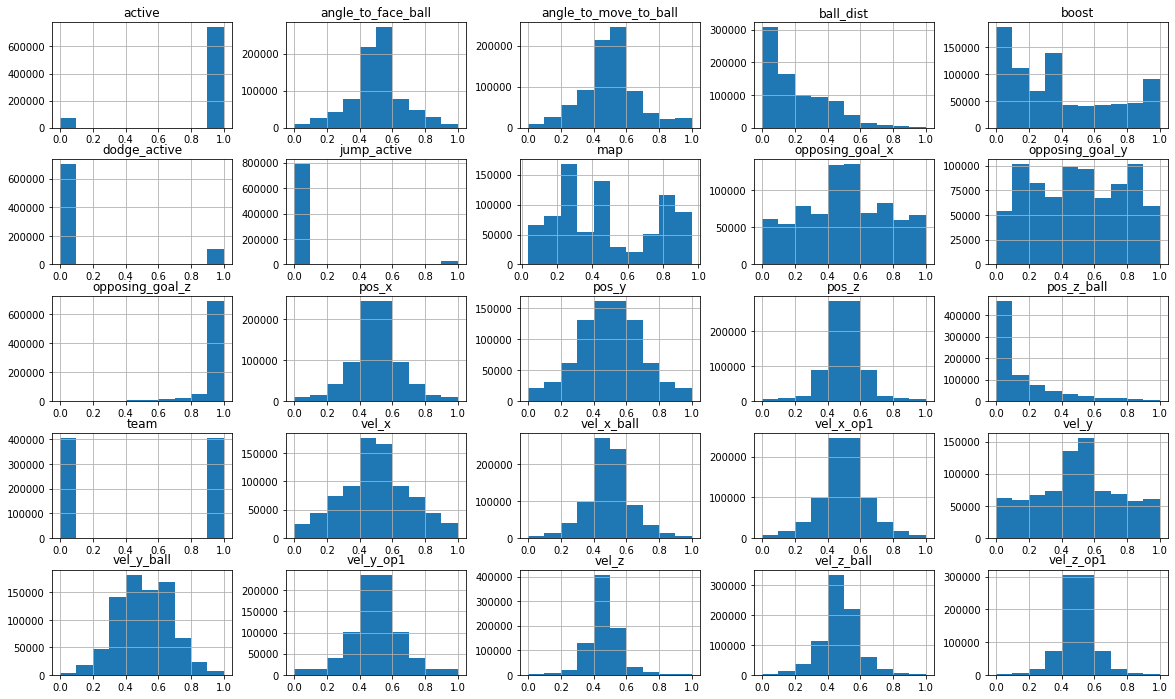

In [76]:
X.hist(figsize=(20, 12))

In [77]:
def take_sample(X, y, quantity):
  if quantity == None: return X, y
  return X[0:quantity], y[0:quantity]


# def split_data(dataframe, shuffle=True, max_val_size=20000, max_test_size=20000):
#   '''
#   Returns the data split into train, val, and test sets.
#   '''
#   if shuffle:
#     dataframe = dataframe.sample(frac=1)
#   m = shuffled.shape[0]
#   size_val_set = min(int(m * 0.2), max_val_size)
#   size_test_set = min(int(m * 0.2), max_test_size)
#   end_test_set = size_val_set + size_test_set

#   val_set = dataframe[0:size_val_set]
#   test_set = dataframe[size_val_set:end_test_set]
#   train_set = dataframe[end_test_set:]
#   return train_set, val_set, test_set

# X_train, X_val, X_test = split_data(X, shuffle=False)

X_shuffled = X#.sample(frac=1)
y_shuffled = y#.sample(frac=1)
assert X_shuffled.shape[0] == y_shuffled.shape[0], f"X has {X_shuffled.shape[0]} rows, but y has {y_shuffled.shape[0]}."
# X_shuffled, y_shuffled = take_sample(X_shuffled, y_shuffled, 3000)
m = X_shuffled.shape[0]

size_val_set = min(int(m * 0.2), 20000)
size_test_set = min(int(m * 0.2), 20000)
end_test_set = size_val_set + size_test_set
X_val = X_shuffled[0:size_val_set]
y_val = y_shuffled[0:size_val_set]
X_test = X_shuffled[size_val_set:end_test_set]
y_test = y_shuffled[size_val_set:end_test_set]
X_train = X_shuffled[end_test_set:]
y_train = y_shuffled[end_test_set:]

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

sum_rows = X_train.shape[0] + X_val.shape[0] + X_test.shape[0]
print(X_train.shape[0] + X_val.shape[0] + X_test.shape[0])
print(X.shape[0])
print(f"We have {X_shuffled.shape[0]} rows in X. We have {sum_rows} in all sub-matrices combined (which should be the same).")
assert(sum_rows == X_shuffled.shape[0])
assert(X_train.shape[0] == y_train.shape[0])

(771120, 25)
(20000, 25)
(20000, 25)
(771120, 2)
(20000, 2)
(20000, 2)
811120
811120
We have 811120 rows in X. We have 811120 in all sub-matrices combined (which should be the same).


In [78]:
X.head(1)

,boost,active,vel_x,vel_y,vel_z,jump_active,dodge_active,ball_dist,angle_to_face_ball,angle_to_move_to_ball,opposing_goal_x,opposing_goal_y,opposing_goal_z,pos_x,pos_y,pos_z,vel_x_op1,vel_y_op1,vel_z_op1,vel_x_ball,vel_y_ball,vel_z_ball,pos_z_ball,map,team
1,0.333333,0.0,0.511038,0.500762,0.412835,0.0,0.0,0.483498,0.535974,0.468108,0.520464,0.166431,0.991607,0.392922,0.110689,0.435351,0.530336,0.480822,0.483624,0.527998,0.457423,0.449038,0.005829,0.333333,1


In [79]:
y.head(1)

,steer,throttle
1,0.0,0.0


## Distributions of controller inputs

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff24edc1828>,
      dtype=object)

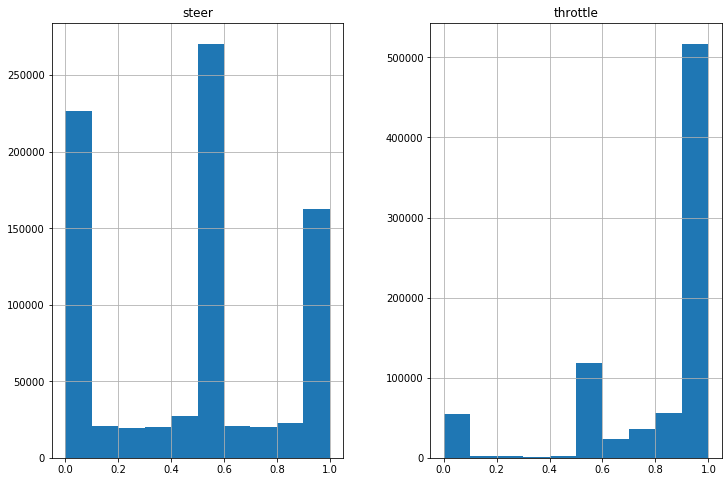

In [80]:
y.hist(figsize=(12, 8))

In [81]:
x_nulls = X.isnull().any()
x_nulls[x_nulls == True]

Series([], dtype: bool)

In [82]:
X_train.describe()

,boost,active,vel_x,vel_y,vel_z,jump_active,dodge_active,ball_dist,angle_to_face_ball,angle_to_move_to_ball,opposing_goal_x,opposing_goal_y,opposing_goal_z,pos_x,pos_y,pos_z,vel_x_op1,vel_y_op1,vel_z_op1,vel_x_ball,vel_y_ball,vel_z_ball,pos_z_ball,map,team
count,771120.000000,771120.000000,771120.000000,771120.000000,771120.000000,771120.000000,771120.000000,771120.000000,771120.000000,771120.000000,771120.000000,771120.000000,771120.000000,771120.000000,771120.000000,771120.000000,771120.000000,771120.000000,771120.000000,771120.000000,771120.000000,771120.000000,771120.000000,771120.000000,771120.000000
mean,0.386018,0.913261,0.499645,0.499507,0.463802,0.029102,0.136804,0.213243,0.505201,0.501281,0.508388,0.501466,0.932953,0.500061,0.499964,0.499540,0.499988,0.499882,0.500011,0.495588,0.514333,0.473023,0.155187,0.477639,0.495597
std,0.323654,0.281452,0.207468,0.253938,0.097744,0.168092,0.343640,0.186097,0.158555,0.168315,0.259159,0.274306,0.135874,0.149675,0.195273,0.117649,0.143347,0.155435,0.102625,0.135497,0.162520,0.116076,0.206089,0.284350,0.499981
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.037037,0.000000
25%,0.121569,1.000000,0.367292,0.322151,0.411163,0.000000,0.000000,0.058845,0.437991,0.416648,0.314565,0.262109,0.945177,0.425532,0.374262,0.447739,0.423628,0.418983,0.448672,0.424779,0.395478,0.417051,0.006442,0.259259,0.000000
50%,0.333333,1.000000,0.499900,0.500004,0.458006,0.000000,0.000000,0.153210,0.505299,0.501552,0.500201,0.499392,0.987015,0.499896,0.499375,0.499702,0.499812,0.500217,0.499527,0.494640,0.509456,0.471447,0.066065,0.407407,0.000000
75%,0.650980,1.000000,0.630627,0.677857,0.512448,0.000000,0.000000,0.343961,0.569733,0.575723,0.713415,0.745257,0.991296,0.574550,0.625533,0.551776,0.576333,0.580953,0.551339,0.564737,0.636073,0.530501,0.219921,0.777778,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.962963,1.000000


## Model

In [83]:
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Conv2D

inputs = Input(shape=X_train.shape[1])

x = Dense(1600, activation='relu')(inputs)

x = Dense(800, activation='relu')(x)
x = Dense(400, activation='relu')(x)
x = Dense(200, activation='relu')(x)
x = Dense(100, activation='relu')(x)

outputs = [] # make one branching output per predicted controller input
for column in get_y_pred_columns():
    sub_net = Dense(50, activation='relu')(x)
    sub_net = Dense(25, activation='relu')(sub_net)
    sub_net = Dense(10, activation='relu')(sub_net)
    sub_net_output = Dense(1, activation='sigmoid', name=column)(sub_net)
    outputs.append(sub_net_output)

model = Model(inputs=inputs, outputs=outputs, name='BittyBot')

model.summary()

learning_rate = 0.0001
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, amsgrad=False)
# losses to try: binary_crossentropy, categorical_crossentropy, mean_squared_error, poisson, mean_squared_logarithmic_error, mean_absolute_error
loss = 'mean_absolute_error'
metrics = ['accuracy']
batch_size = 128
epochs = 2
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

Model: "BittyBot"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 25)]         0                                            
__________________________________________________________________________________________________
dense_11 (Dense)                (None, 1600)         41600       input_2[0][0]                    
__________________________________________________________________________________________________
dense_12 (Dense)                (None, 800)          1280800     dense_11[0][0]                   
__________________________________________________________________________________________________
dense_13 (Dense)                (None, 400)          320400      dense_12[0][0]                   
___________________________________________________________________________________________

In [84]:
x_nulls = X.isnull().any()
print(x_nulls[x_nulls == True])
y_nulls = y.isnull().any()
print(y_nulls[y_nulls == True])
# print(X_train.shape)
# print(y_train.shape)
# print(X_val.shape)
# print(y_val.shape)

def train(model, X_train, y_train, X_val, y_val, batch_size=32, epochs=25):
    print(y_train.shape)
#     X_train, y_train, X_val, y_val = np.asarray(X_train), np.asarray(y_train), np.asarray(X_val), np.asarray(y_val)
    X_train, X_val = np.asarray(X_train), np.asarray(X_val)

    def get_outputs(df, num_outputs):
        '''Returns first columns of df as an array of numpy arrays.'''
        return [np.asarray(df.iloc[:, i]) for i in range(num_outputs)]
    
    num_outputs = len(get_y_pred_columns())

    start = timer()
#     history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val))
    history = model.fit(
        X_train,
        get_outputs(y_train, num_outputs),
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(X_val, get_outputs(y_val, num_outputs)),
        )
    end = timer()
    print(f"The model took {end - start}s to train.")
    return history
    
history = train(model, X_train, y_train, X_val, y_val, batch_size, epochs)

Series([], dtype: bool)
Series([], dtype: bool)
(771120, 2)
Train on 771120 samples, validate on 20000 samples
Epoch 1/100
771120/771120 [==============================] - 28s 37us/sample - loss: 0.4086 - steer_loss: 0.2355 - throttle_loss: 0.1731 - steer_accuracy: 0.2731 - throttle_accuracy: 0.4905 - val_loss: 0.3787 - val_steer_loss: 0.2306 - val_throttle_loss: 0.1485 - val_steer_accuracy: 0.2966 - val_throttle_accuracy: 0.4018
Epoch 2/100
771120/771120 [==============================] - 27s 36us/sample - loss: 0.3920 - steer_loss: 0.2314 - throttle_loss: 0.1606 - steer_accuracy: 0.2791 - throttle_accuracy: 0.4950 - val_loss: 0.3718 - val_steer_loss: 0.2260 - val_throttle_loss: 0.1462 - val_steer_accuracy: 0.2910 - val_throttle_accuracy: 0.4024
Epoch 3/100
771120/771120 [==============================] - 27s 35us/sample - loss: 0.3775 - steer_loss: 0.2224 - throttle_loss: 0.1551 - steer_accuracy: 0.2832 - throttle_accuracy: 0.4952 - val_loss: 0.3687 - val_steer_loss: 0.2224 - val_thr

Epoch 26/100
771120/771120 [==============================] - 27s 35us/sample - loss: 0.2551 - steer_loss: 0.1495 - throttle_loss: 0.1057 - steer_accuracy: 0.3319 - throttle_accuracy: 0.4963 - val_loss: 0.3849 - val_steer_loss: 0.2267 - val_throttle_loss: 0.1589 - val_steer_accuracy: 0.2928 - val_throttle_accuracy: 0.4003
Epoch 27/100
771120/771120 [==============================] - 27s 35us/sample - loss: 0.2531 - steer_loss: 0.1481 - throttle_loss: 0.1051 - steer_accuracy: 0.3327 - throttle_accuracy: 0.4965 - val_loss: 0.3839 - val_steer_loss: 0.2285 - val_throttle_loss: 0.1557 - val_steer_accuracy: 0.2982 - val_throttle_accuracy: 0.4020
Epoch 28/100
771120/771120 [==============================] - 27s 35us/sample - loss: 0.2508 - steer_loss: 0.1464 - throttle_loss: 0.1044 - steer_accuracy: 0.3340 - throttle_accuracy: 0.4965 - val_loss: 0.3842 - val_steer_loss: 0.2292 - val_throttle_loss: 0.1557 - val_steer_accuracy: 0.2968 - val_throttle_accuracy: 0.4024
Epoch 29/100
771120/771120 [

771120/771120 [==============================] - 27s 35us/sample - loss: 0.2104 - steer_loss: 0.1223 - throttle_loss: 0.0882 - steer_accuracy: 0.3499 - throttle_accuracy: 0.5081 - val_loss: 0.3912 - val_steer_loss: 0.2319 - val_throttle_loss: 0.1602 - val_steer_accuracy: 0.3021 - val_throttle_accuracy: 0.4004
Epoch 52/100
771120/771120 [==============================] - 27s 35us/sample - loss: 0.2094 - steer_loss: 0.1216 - throttle_loss: 0.0878 - steer_accuracy: 0.3505 - throttle_accuracy: 0.5081 - val_loss: 0.3905 - val_steer_loss: 0.2317 - val_throttle_loss: 0.1594 - val_steer_accuracy: 0.2978 - val_throttle_accuracy: 0.4010
Epoch 53/100
771120/771120 [==============================] - 27s 35us/sample - loss: 0.2128 - steer_loss: 0.1210 - throttle_loss: 0.0919 - steer_accuracy: 0.3509 - throttle_accuracy: 0.5049 - val_loss: 0.3945 - val_steer_loss: 0.2367 - val_throttle_loss: 0.1587 - val_steer_accuracy: 0.3039 - val_throttle_accuracy: 0.4014
Epoch 54/100
771120/771120 [=============

771120/771120 [==============================] - 27s 35us/sample - loss: 0.1913 - steer_loss: 0.1099 - throttle_loss: 0.0814 - steer_accuracy: 0.3575 - throttle_accuracy: 0.5103 - val_loss: 0.3939 - val_steer_loss: 0.2362 - val_throttle_loss: 0.1583 - val_steer_accuracy: 0.3013 - val_throttle_accuracy: 0.4016
Epoch 77/100
771120/771120 [==============================] - 27s 35us/sample - loss: 0.1894 - steer_loss: 0.1095 - throttle_loss: 0.0799 - steer_accuracy: 0.3578 - throttle_accuracy: 0.5112 - val_loss: 0.3908 - val_steer_loss: 0.2327 - val_throttle_loss: 0.1590 - val_steer_accuracy: 0.3029 - val_throttle_accuracy: 0.4009
Epoch 78/100
771120/771120 [==============================] - 27s 35us/sample - loss: 0.1893 - steer_loss: 0.1096 - throttle_loss: 0.0798 - steer_accuracy: 0.3579 - throttle_accuracy: 0.5112 - val_loss: 0.3992 - val_steer_loss: 0.2352 - val_throttle_loss: 0.1642 - val_steer_accuracy: 0.3008 - val_throttle_accuracy: 0.4001
Epoch 79/100
771120/771120 [=============

## Loss and Accuracy

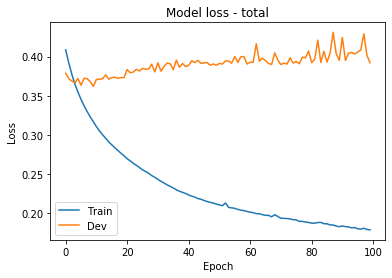

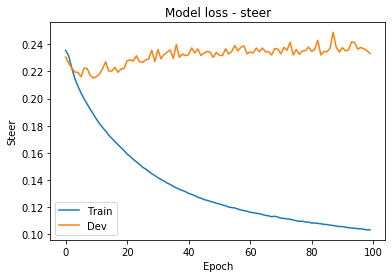

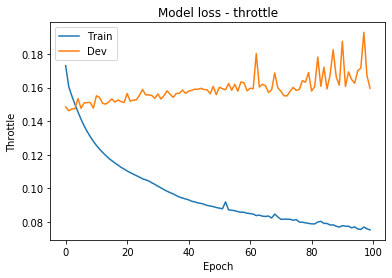

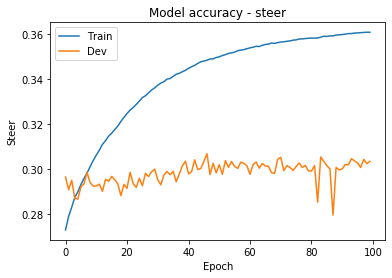

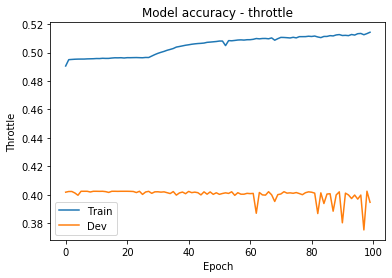

In [85]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss - total')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Dev'], loc='best')
plt.show()



for column in get_y_pred_columns():
    plt.plot(history.history[f'{column}_loss'])
    plt.plot(history.history[f'val_{column}_loss'])
    plt.title(f'Model loss - {column}')
    plt.ylabel(column.title())
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Dev'], loc='best')
    plt.show()

for column in get_y_pred_columns():
    plt.plot(history.history[f'{column}_accuracy'])
    plt.plot(history.history[f'val_{column}_accuracy'])
    plt.title(f'Model accuracy - {column}')
    plt.ylabel(column.title())
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Dev'], loc='best')
    plt.show()

In [86]:
y_pred = model.predict(np.asarray(X_val))
print(y_pred.shape)

AttributeError: 'list' object has no attribute 'shape'

In [ ]:
first_row = X_val.iloc[0]
print(first_row.shape)
print(type(first_row))
arr = np.ndarray((1, first_row.shape[0]), buffer=np.array(first_row))
print(arr)
print(arr.shape)
output = model.predict(arr)

In [ ]:
try:
  print(output.flatten()[1])
except IndexError as e:
  pass

In [ ]:
X_val.head(1)

In [ ]:
one_prediction = model.predict(np.asarray(X_test.head(1)))

def get_value_dict(y, value):
  return dict(zip(y.columns, value))

initial_values = get_value_dict(y, one_prediction[0])
initial_values


In [ ]:
predictions = pd.DataFrame(y_pred)
predictions.columns = get_y_pred_columns()
predictions.describe()

## Prediction Distributions

In [ ]:
def interpret_result(result):
  final_values = result.copy()
  # for action in ['handbrake', 'boost_active', 'dodge_active', 'double_jump_active', 'jump_active']:
  #   final_values[action] = 1 if initial_values[action] >= 0.5 else 0
  return final_values


# m_val = y_pred.shape[0]
# start = 700
# to_show = 50
# for i in range(start, start + to_show): #m_val):
#   result = y_pred[i]
#   prediction = interpret_result(get_value_dict(y_val, y_pred[i]))
#   print('Predict:', prediction)
#   actual = interpret_result(get_value_dict(y_val, y_val.iloc[i]))
#   print('Actual: ', actual)
#   print('--')

output_df = pd.DataFrame(y_pred)
output_df.columns = y.columns[0:y_pred.shape[1]]
output_df.hist(figsize=(14, 5))

In [ ]:
y_val.hist(figsize=(14, 5));

In [ ]:
model.save('model_relative.h5')

# @TODO Make this work on Windows.
# !mkdir -p frankenbot/saved_model_relative/
# classifier.save('frankenbot/saved_model_relative/1')

In [ ]:
output_df['steer'].hist()

In [ ]:
def round_outliers(value):
    if value < 0: return 0
    if value > 1: return 1
    return value

output_df['steer'].apply(round_outliers).hist()